## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-13 16:16:12.820657


{1: 24.4,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.8,
 50: 31.6,
 60: 33.3,
 70: 35.2,
 80: 37.5,
 90: 41.0,
 95: 43.8,
 99: 49.4}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-06-14 13:17:02.014756


{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.5,
 30: 8.7,
 40: 8.7,
 50: 8.8,
 60: 8.9,
 70: 9.1,
 80: 9.2,
 90: 9.4,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-13 23:05:32.824387


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev1),
 'tai_flop_size': array([36.1, 34.8, 42.7, ..., 28.1, 31.4, 45.4]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.64, lognorm_sd=0.72, norm_mean=0.41, norm_sd=0.42) (version 0.28-dev1),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev1),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev1),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 17686.41it/s]


{1: 0.00141,
 5: 0.00199,
 10: 0.00243,
 20: 0.00304,
 30: 0.00358,
 40: 0.00419,
 50: 0.0048,
 60: 0.00554,
 70: 0.0064,
 80: 0.00814,
 90: 0.01342,
 95: 0.02275,
 99: 0.04231}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.141%',
 5: '0.199%',
 10: '0.243%',
 20: '0.304%',
 30: '0.358%',
 40: '0.419%',
 50: '0.48%',
 60: '0.554%',
 70: '0.64%',
 80: '0.814%',
 90: '1.342%',
 95: '2.275%',
 99: '4.231%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '35.4 billion',
 5: '50.1 billion',
 10: '61.2 billion',
 20: '76.4 billion',
 30: '89.9 billion',
 40: '105.0 billion',
 50: '120.7 billion',
 60: '139.0 billion',
 70: '160.8 billion',
 80: '204.1 billion',
 90: '337.4 billion',
 95: '571.5 billion',
 99: '1.1 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6060.16it/s]


{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.038%',
 60: '0.056%',
 70: '0.082%',
 80: '0.128%',
 90: '0.237%',
 95: '0.395%',
 99: '1.011%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.003%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.027%',
 50: '0.038%',
 60: '0.056%',
 70: '0.082%',
 80: '0.128%',
 90: '0.237%',
 95: '0.395%',
 99: '1.011%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '348.5 million',
 5: '833.1 million',
 10: '1.4 billion',
 20: '2.8 billion',
 30: '4.6 billion',
 40: '6.7 billion',
 50: '9.6 billion',
 60: '14.0 billion',
 70: '20.6 billion',
 80: '32.1 billion',
 90: '59.5 billion',
 95: '99.2 billion',
 99: '253.8 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3509.07it/s]


{1: 0.4,
 5: 1.1,
 10: 1.8,
 20: 3.6,
 30: 5.8,
 40: 8.9,
 50: 13.4,
 60: 20.0,
 70: 30.6,
 80: 52.8,
 90: 111.0,
 95: 189.7,
 99: 580.7}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~727.0 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~151.4 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.5 year to a max of 0.012603% of GDP (initially ~3.2 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 33.1 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.7 logFLOP which costs 1

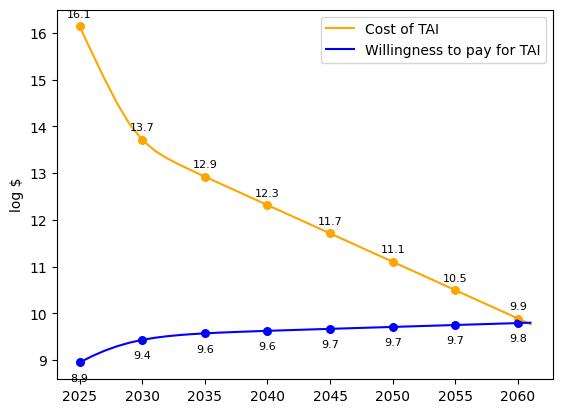



## SAMPLE RUN 2 ##

In this simulation:
* It takes 45.8 log FLOP (~6.3 trillion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~251.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~378.8 million).
* This doubles every 1.1 year to a max of 0.031201% of GDP (initially ~7.8 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 45.8 logFLOP which costs 27.7 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 45.5 logFLOP which costs 27.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 45.3 logFLOP which costs 26.9 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 45.0 logFLOP which 

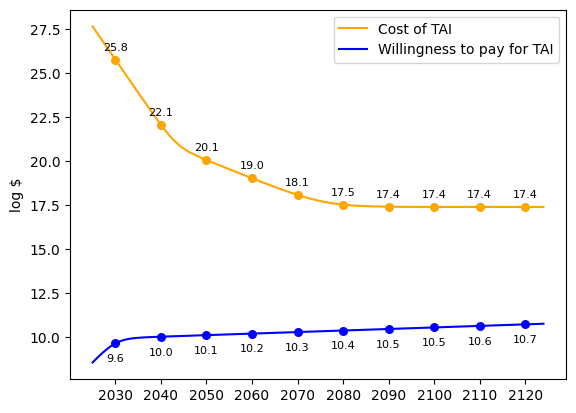



## SAMPLE RUN 3 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~879.9 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.4 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~643.6 million).
* This doubles every 1.1 year to a max of 0.013457% of GDP (initially ~3.4 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 8.7 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP whic

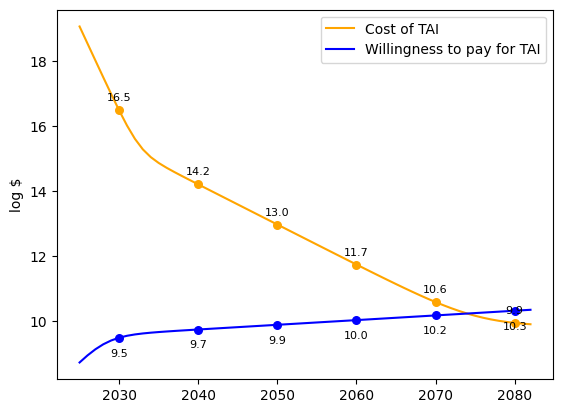



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:12, 816.60it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1009.76it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2029',
 '10%: 2030',
 '15%: 2031',
 '20%: 2032',
 '25%: 2033',
 '35%: 2035',
 '50%: 2040',
 '60%: 2047',
 '75%: 2066',
 '80%: 2093',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 10 years from now',
 '50%: 15 years from now',
 '60%: 22 years from now',
 '75%: 41 years from now',
 '80%: 68 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 33 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.4%
2027-2029: 6.3%
2030-2034: 24.1%
2035-2039: 16.2%
2040-2049: 14.1%
2050-2059: 8.7%
2060-2069: 5.2%
2070-2079: 2.5%
2080-2089: 1.3%
2090-2099: 0.5%
2100-2109: 0.7%
2110-2119: 0.5%
>2125: 18.4%


## TA



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

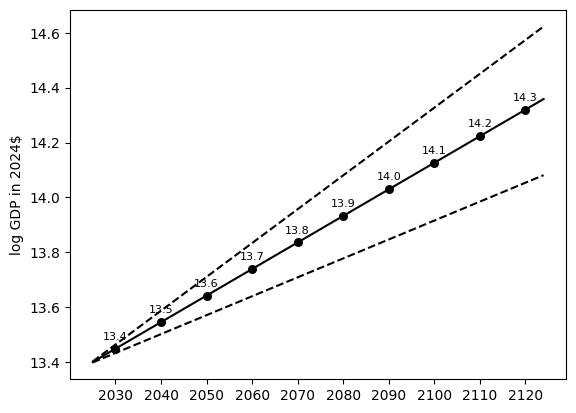

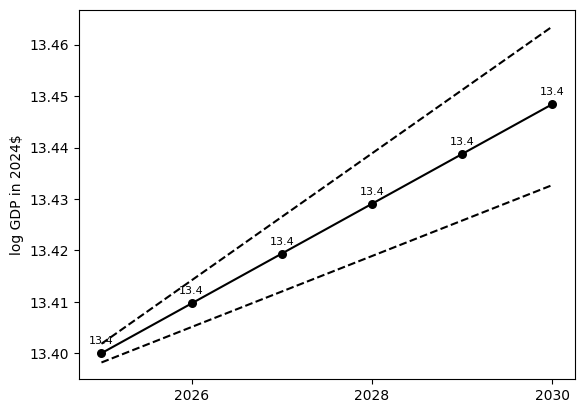



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.2 (~14.8 billion) 80% CI 9.5 (~3.5 billion) - 11.1 (~121.5 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.4 (~27.6 billion) 80% CI 9.9 (~7.8 billion) - 11.3 (~193.0 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.7 (~49.4 billion) 80% CI 10.2 (~14.5 billion) - 11.5 (~302.8 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 10.9 (~82.3 billion) 80% CI 10.3 (~21.7 billion) - 11.7 (~466.1 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.1 (~125.1 billion) 80% CI 10.4 (~27.1 billion) - 11.8 (~698.6 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.2 (~171.0 billion) 80% CI 10.5 (~30.1 billion) - 12.0 (~1.0 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure 1

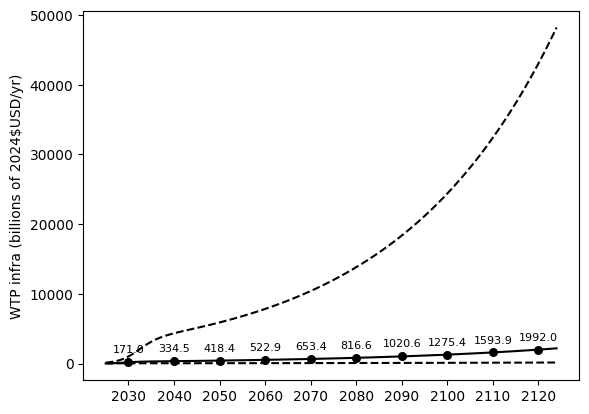

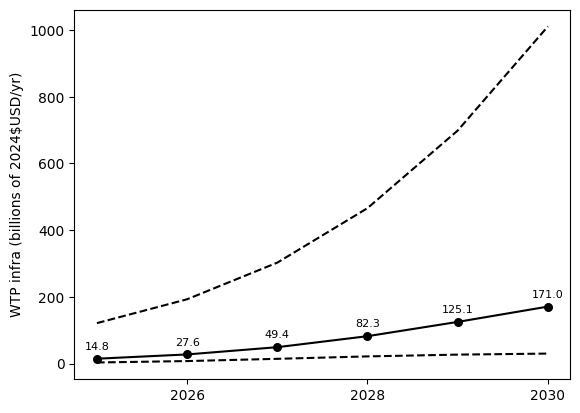



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 8.8 (~592.0 million) 80% CI 8.5 (~351.0 million) - 9.2 (~1.5 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.0 (~1.1 billion) 80% CI 8.9 (~775.7 million) - 9.4 (~2.4 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.3 (~2.0 billion) 80% CI 9.2 (~1.4 billion) - 9.6 (~3.8 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.5 (~3.3 billion) 80% CI 9.3 (~2.2 billion) - 9.8 (~5.8 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.7 (~5.0 billion) 80% CI 9.4 (~2.7 billion) - 9.9 (~8.7 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.8 (~6.8 billion) 80% CI 9.5 (~3.0 billion) - 10.1 (~12.6 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 9.9 (~8.5 billion) 80% CI 9.5 (~

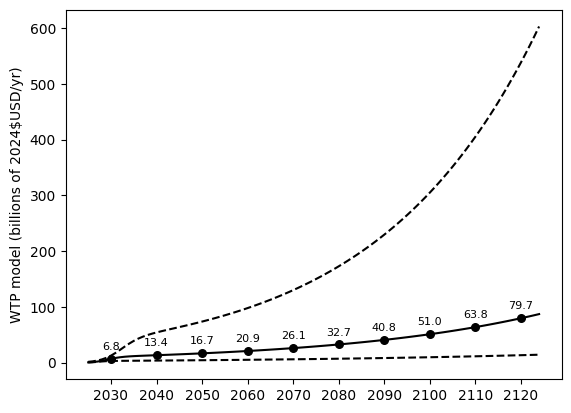

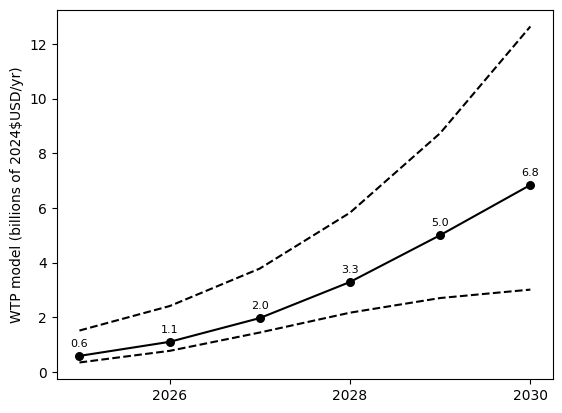



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.6 (~39.8 nonillion) 80% CI 27.1 (~1.2 octillion) - 37.5 (~31.6 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.3 (~20.5 nonillion) 80% CI 26.8 (~637.7 septillion) - 37.3 (~19.4 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.0 (~10.5 nonillion) 80% CI 26.5 (~337.7 septillion) - 37.1 (~11.9 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.7 (~5.5 nonillion) 80% CI 26.3 (~181.5 septillion) - 36.9 (~7.3 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.5 (~3.0 nonillion) 80% CI 26.0 (~100.2 septillion) - 36.6 (~4.5 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.2 (~1.7 nonillion) 80% CI 25.8 (~57.9 septillion) - 36.4 (~2.7 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.0 (~1.0 nonillion) 80% CI 25.6 (~35.9 septillion) - 36.2 (~1.7 thousand decillion)
Year: 2032 - logFLOP needed for TAI 29.9 (~726.0 octillion) 80% CI 25.

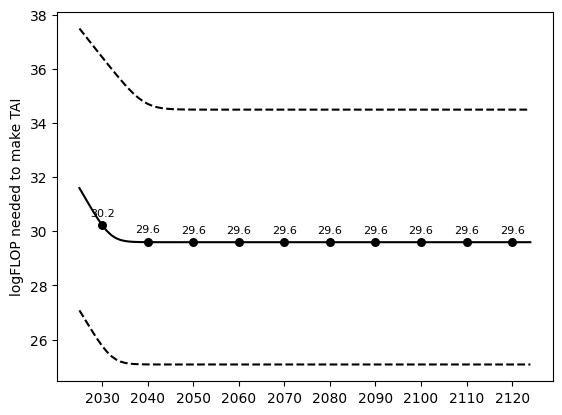

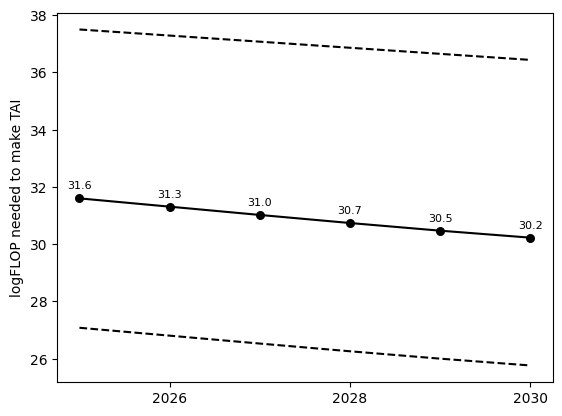



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.1 quintillion) 80% CI 17.9 (~792.6 quadrillion) - 18.7 (~4.9 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.7 quintillion) 80% CI 18.0 (~1.1 quintillion) - 18.8 (~6.3 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.6 (~3.6 quintillion) 80% CI 18.2 (~1.5 quintillion) - 18.9 (~8.1 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.7 quintillion) 80% CI 18.3 (~2.0 quintillion) - 19.0 (~10.4 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~6.2 quintillion) 80% CI 18.4 (~2.7 quintillion) - 19.1 (~13.4 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~8.2 quintillion) 80% CI 18.6 (~3.7 quintillion) - 19.2 (~17.2 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.7 quintillion) 80% CI 18.7 (~5.0 quintillion) - 19.3 (~22.1 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.2 (~14.1 quintillion) 80% CI 18.8 (~6.8 quintillion) - 19.5 (~28.4 quintillion)
Year: 2033 - lo

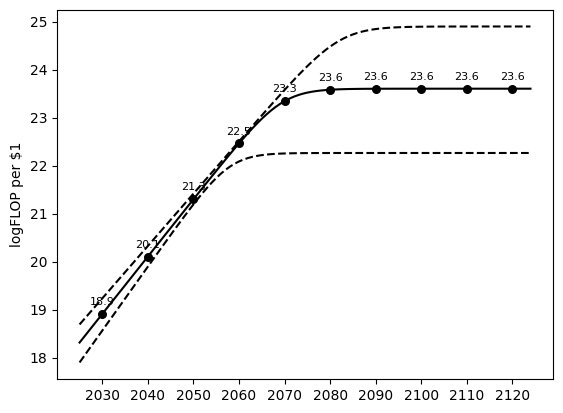

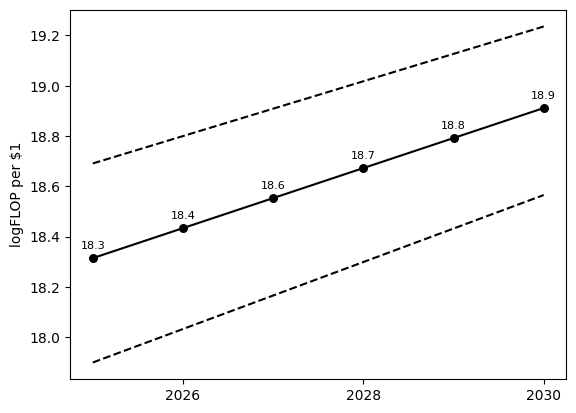



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

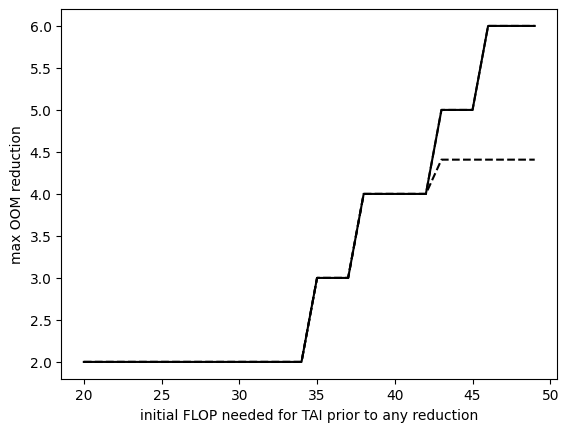



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 21 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 22 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 23 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 24 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 25 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 26 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 27 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 28 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 29 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 30 -> algo doubling rate 1.5yrs (80% CI: 2.14 to 2.14)
TAI log FLOP 31 -> algo doubling rate 1.01yrs (80% CI: 1.64 to 1.64)
TAI log FLOP 32 -> algo doubling rate 1.01yrs (80% CI: 1.14 to 1.14)
TAI log FLOP 33 -> algo doubling rate 1.01yrs (80% CI: 1.14 t

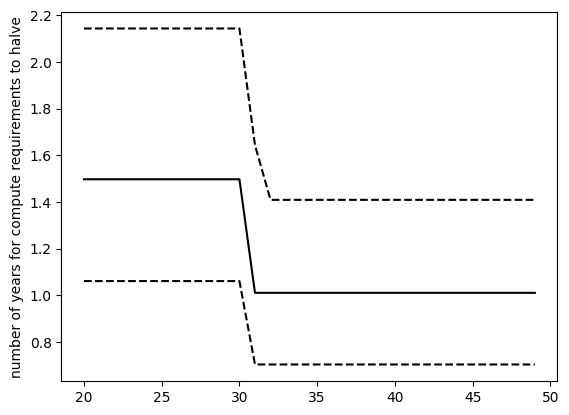



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.3 log 2024$USD to buy TAI (~19.3 trillion) 80% CI 9.2 (~1.5 billion) - 18.8 (~6.4 quintillion)
Year: 2026 - 12.9 log 2024$USD to buy TAI (~7.5 trillion) 80% CI 8.8 (~592.0 million) - 18.5 (~3.1 quintillion)
Year: 2027 - 12.5 log 2024$USD to buy TAI (~2.9 trillion) 80% CI 8.4 (~230.7 million) - 18.2 (~1.5 quintillion)
Year: 2028 - 12.1 log 2024$USD to buy TAI (~1.2 trillion) 80% CI 8.0 (~91.2 million) - 17.8 (~697.0 quadrillion)
Year: 2029 - 11.7 log 2024$USD to buy TAI (~478.3 billion) 80% CI 7.6 (~37.1 million) - 17.5 (~332.5 quadrillion)
Year: 2030 - 11.3 log 2024$USD to buy TAI (~207.2 billion) 80% CI 7.2 (~15.8 million) - 17.2 (~158.9 quadrillion)
Year: 2031 - 11.0 log 2024$USD to buy TAI (~97.7 billion) 80% CI 6.9 (~7.2 million) - 16.9 (~76.2 quadrillion)
Year: 2032 - 10.7 log 2024$USD to buy TAI (~51.4 billion) 80% CI 6.6 (~3.6 million) - 16.6 (~36.7 quadrillion)
Year: 2033

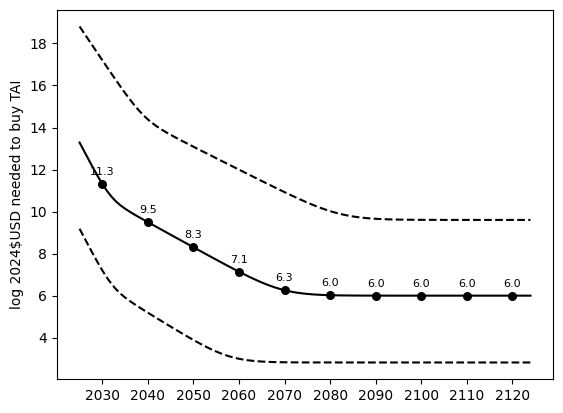

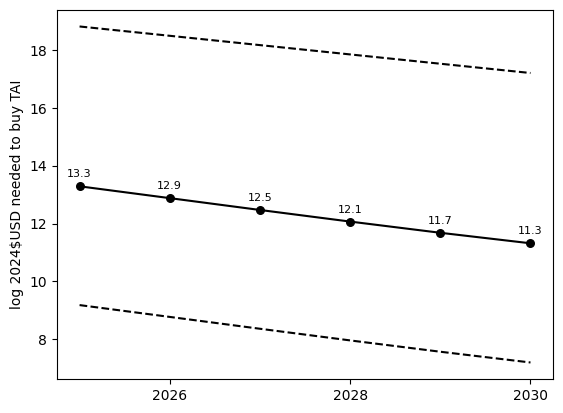



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.1 (~1.2 octillion) 80% CI 26.4 (~278.2 septillion) - 27.9 (~7.5 octillion)
Year: 2026 - max log FLOP 27.5 (~3.0 octillion) 80% CI 26.9 (~835.6 septillion) - 28.2 (~15.2 octillion)
Year: 2027 - max log FLOP 27.8 (~7.1 octillion) 80% CI 27.3 (~2.1 octillion) - 28.5 (~30.7 octillion)
Year: 2028 - max log FLOP 28.2 (~15.5 octillion) 80% CI 27.6 (~4.3 octillion) - 28.8 (~60.7 octillion)
Year: 2029 - max log FLOP 28.5 (~31.0 octillion) 80% CI 27.9 (~7.3 octillion) - 29.1 (~117.0 octillion)
Year: 2030 - max log FLOP 28.7 (~55.8 octillion) 80% CI 28.0 (~11.1 octillion) - 29.3 (~217.5 octillion)
Year: 2031 - max log FLOP 29.0 (~90.9 octillion) 80% CI 28.2 (~15.9 octillion) - 29.6 (~386.8 octillion)
Year: 2032 - max log FLOP 29.1 (~137.5 octillion) 80% CI 28.3 (~22.3 octillion) - 29.8 (~654.3 octillion)
Year: 2033 - max log FLOP 29.3 (~197.6 octillion) 80% CI 28.5 (~30.9 octillion) - 30.0 (~1.1 nonillion)
Year: 2034 - max log FLOP 29.

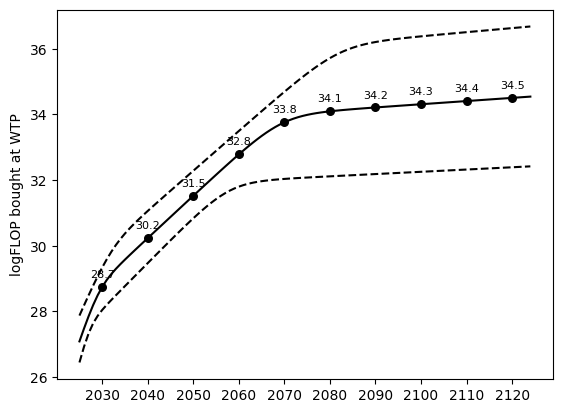

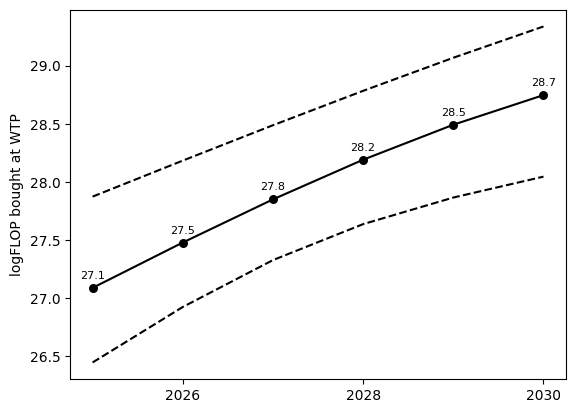



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.1 (~1.2 octillion) 80% CI 26.4 (~278.2 septillion) - 27.9 (~7.5 octillion)
Year: 2026 - max log effective 2024-FLOP 27.8 (~5.8 octillion) 80% CI 27.1 (~1.3 octillion) - 28.6 (~40.6 octillion)
Year: 2027 - max log effective 2024-FLOP 28.4 (~26.7 octillion) 80% CI 27.7 (~5.5 octillion) - 29.3 (~218.3 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~112.4 octillion) 80% CI 28.3 (~18.1 octillion) - 30.1 (~1.1 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.6 (~416.6 octillion) 80% CI 28.7 (~48.8 octillion) - 30.8 (~5.7 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.1 (~1.3 nonillion) 80% CI 29.1 (~116.0 octillion) - 31.4 (~26.3 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.5 (~3.5 nonillion) 80% CI 29.4 (~255.1 octillion) - 32.0 (~104.0 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~7.5 nonillion) 80% CI 29.7 (

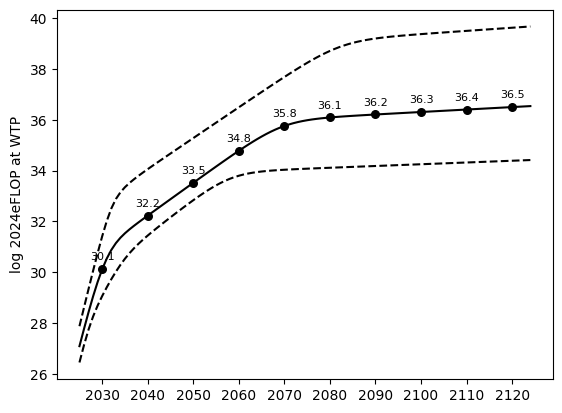

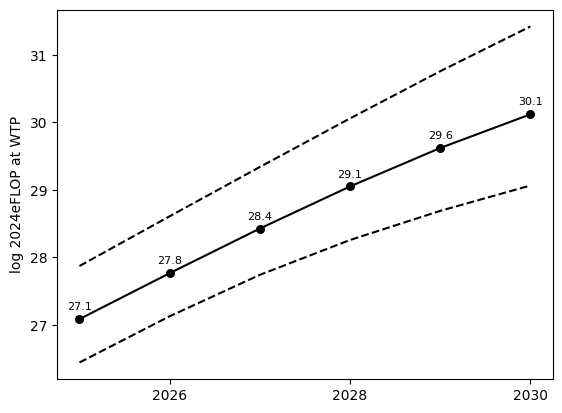


## TAI FLOP SIZE ##
{1: 24.099,
 5: 25.5,
 10: 26.2,
 20: 27.080000000000002,
 30: 27.97,
 40: 29.6,
 50: 31.6,
 60: 33.1,
 70: 35.1,
 80: 37.5,
 90: 40.31,
 95: 43.0,
 99: 49.10999999999999}


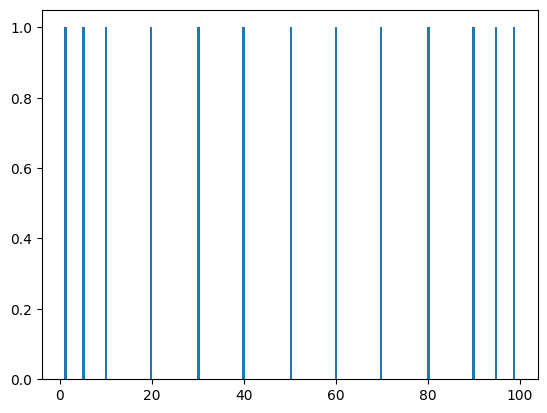



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.118827403812838,
 5: 3.0010438494438425,
 10: 3.5786206096779227,
 20: 4.4079209469723395,
 30: 5.071493252235078,
 40: 5.833622114787096,
 50: 6.63264190133244,
 60: 7.462955877447068,
 70: 8.391396667539842,
 80: 9.888961140775434,
 90: 12.507341076418909,
 95: 15.351356777183078,
 99: 20.131778832613122}


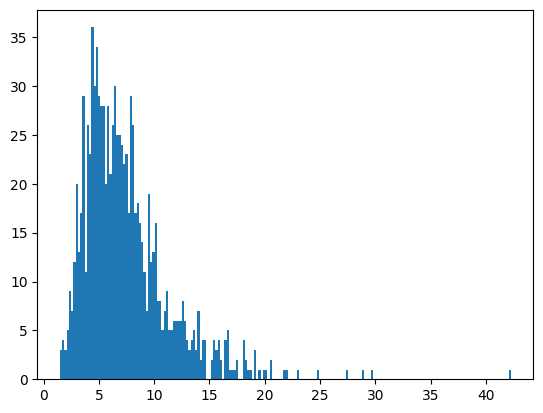



## MIN ALGO DOUBLING RATE ##
{1: 0.3730071228230787,
 5: 0.48329322056756585,
 10: 0.5650170200349688,
 20: 0.704076441488945,
 30: 0.8096694545534968,
 40: 0.9080454226449348,
 50: 1.011015075792578,
 60: 1.1128248051023562,
 70: 1.2473568925116547,
 80: 1.4093482976078897,
 90: 1.6998898729302507,
 95: 2.025488957261901,
 99: 2.6500071252045}


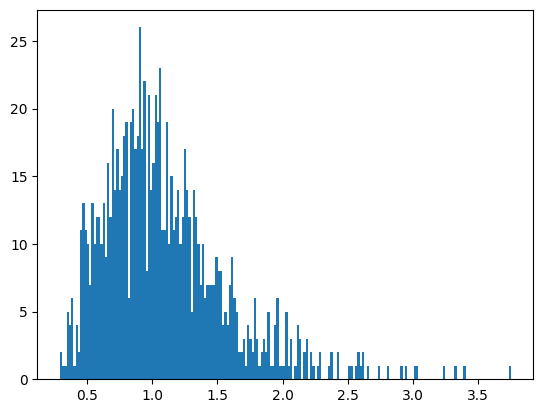



## MAX ALGO DOUBLING RATE ##
{1: 0.5496643996097232,
 5: 0.7582442909072179,
 10: 0.8764594464277355,
 20: 1.061396222930784,
 30: 1.2055653519087544,
 40: 1.366615037799344,
 50: 1.4975251532935112,
 60: 1.667362169654316,
 70: 1.8536323142940865,
 80: 2.1435408151791724,
 90: 2.597633108376347,
 95: 2.9955793271072295,
 99: 4.062660691431074}


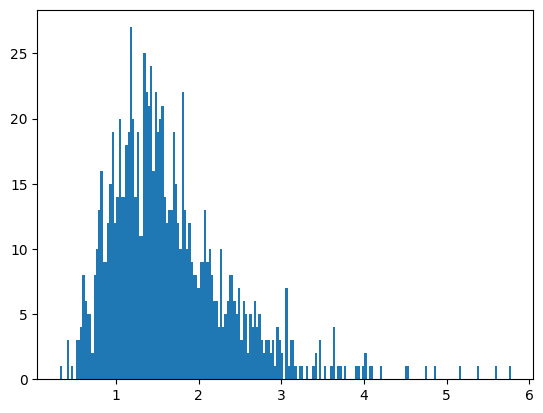



## INITIAL FLOP PER DOLLAR ##
{1: 17.275112085175177,
 5: 17.524683304509967,
 10: 17.66463746030801,
 20: 17.8990787138492,
 30: 18.0460984547061,
 40: 18.18813063767335,
 50: 18.31425758570585,
 60: 18.419891834389727,
 70: 18.543005024241697,
 80: 18.690913635702508,
 90: 18.901224511181987,
 95: 19.058069638658317,
 99: 19.26374498444033}


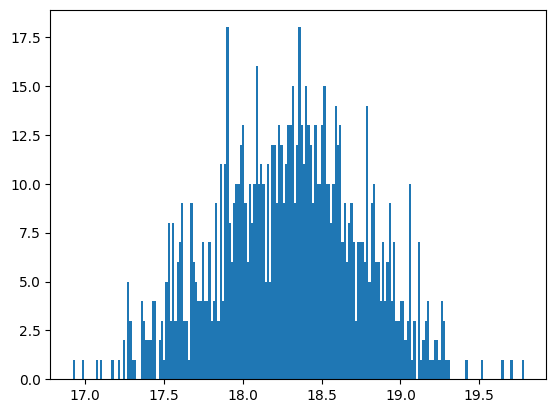



## FLOP HALVING RATE ##
{1: 1.7565929538458818,
 5: 1.9838214292264027,
 10: 2.118244815903493,
 20: 2.259141733482556,
 30: 2.3549819386316564,
 40: 2.439336442499161,
 50: 2.520398032254297,
 60: 2.586850925596042,
 70: 2.6645710323240333,
 80: 2.761836477257141,
 90: 2.8889858054386712,
 95: 2.999763130302804,
 99: 3.243051854557737}


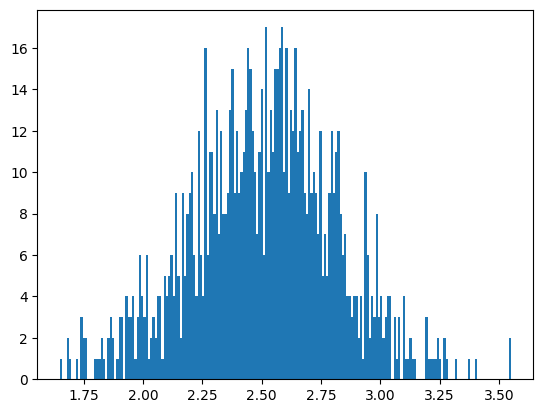



## MAX FLOP PER DOLLAR ##
{1: 20.150287377736912,
 5: 21.057586010350143,
 10: 21.60258785100773,
 20: 22.26263584191641,
 30: 22.840069968228363,
 40: 23.208368608528463,
 50: 23.601937638344108,
 60: 23.9837796381973,
 70: 24.385860872322972,
 80: 24.8977339750763,
 90: 25.521967384154404,
 95: 26.04908934800161,
 99: 26.819986448709894}


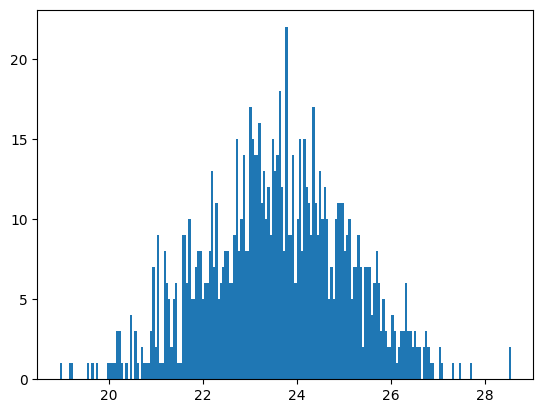



## INITIAL PAY ##
{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.6,
 30: 8.6,
 40: 8.7,
 50: 8.8,
 60: 8.9,
 70: 9.029999999999996,
 80: 9.2,
 90: 9.4,
 95: 9.6,
 99: 10.0}


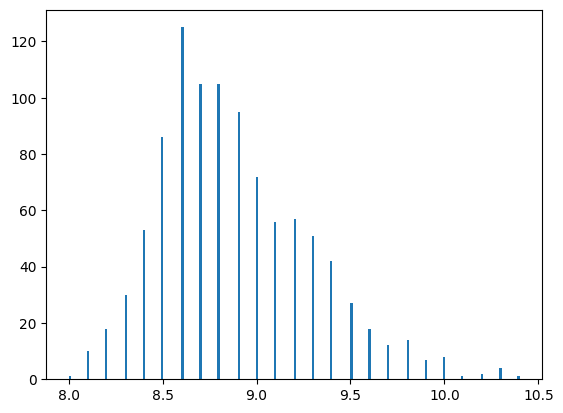



## INITIAL GDP ##
{1: 24815933965712.3,
 5: 24902011862845.48,
 10: 24963885501682.766,
 20: 25016349189947.89,
 30: 25056017495076.664,
 40: 25086072207492.61,
 50: 25120444453176.04,
 60: 25152800827912.992,
 70: 25187516471224.496,
 80: 25226728255425.816,
 90: 25286987000254.02,
 95: 25336535998783.973,
 99: 25406719363059.758}


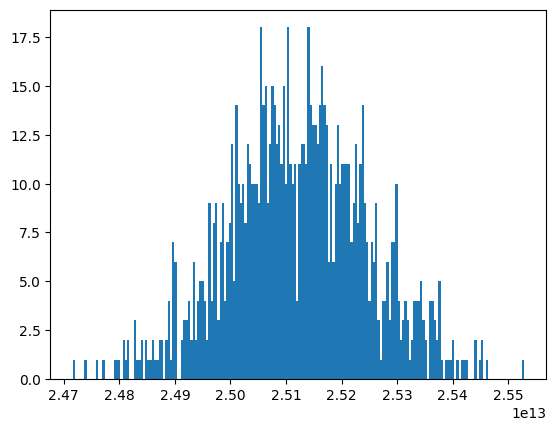



## GDP GROWTH ##
{1: 1.005,
 5: 1.0093453299538404,
 10: 1.0126234731730828,
 20: 1.0160083514894762,
 30: 1.0185447067493045,
 40: 1.0204797242747594,
 50: 1.0225434665196418,
 60: 1.0241733413839211,
 70: 1.0261781097091143,
 80: 1.0288092398645683,
 90: 1.0316178870858541,
 95: 1.0337795341777058,
 99: 1.0390944053321947}


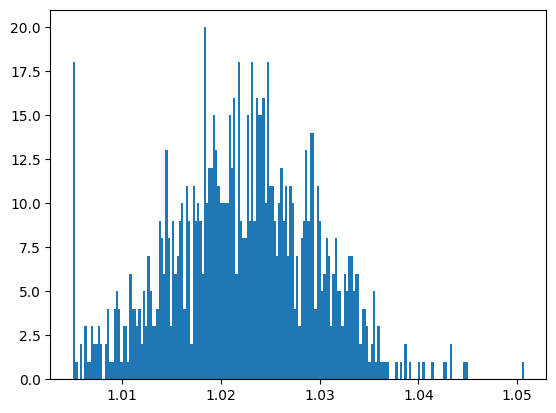



## MAX GDP FRAC ##
{1: 1.688470558657355e-05,
 5: 3.770762679573635e-05,
 10: 6.147743434970969e-05,
 20: 0.00011852261827501344,
 30: 0.00017322753397638232,
 40: 0.0002625357355423396,
 50: 0.00038155305094805054,
 60: 0.0005799386991216667,
 70: 0.0009167590691748502,
 80: 0.0014362451760095113,
 90: 0.002691847624121592,
 95: 0.004032053588367381,
 99: 0.009725428004604955}


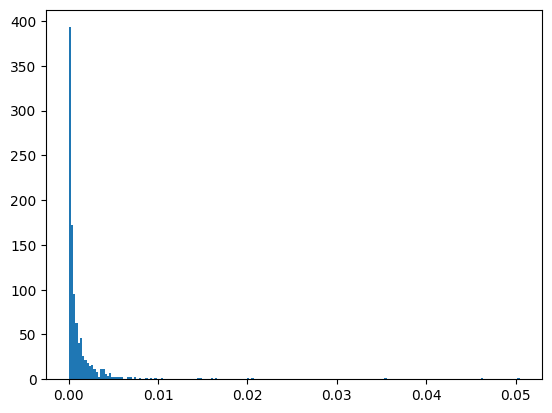



## SPEND DOUBLING TIME ##
{1: 0.4201523717632869,
 5: 0.5217379826142166,
 10: 0.5852878235399547,
 20: 0.7184370917574386,
 30: 0.8107075206517487,
 40: 0.9145000513350238,
 50: 1.0192824709438604,
 60: 1.129469923011069,
 70: 1.266431367645118,
 80: 1.4226918766378929,
 90: 1.737103357856994,
 95: 2.0357071809492706,
 99: 2.865301416665077}


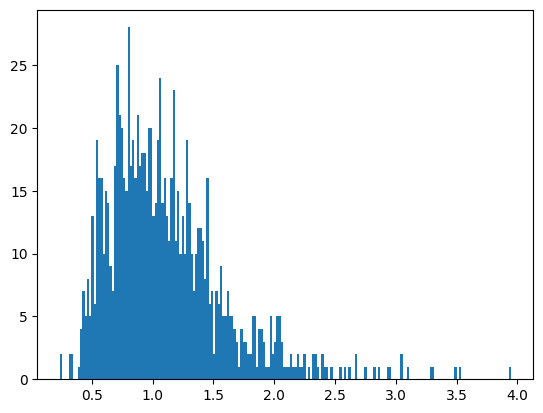





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 7,
 99: 15}
## Chance of nonscaling delay ##


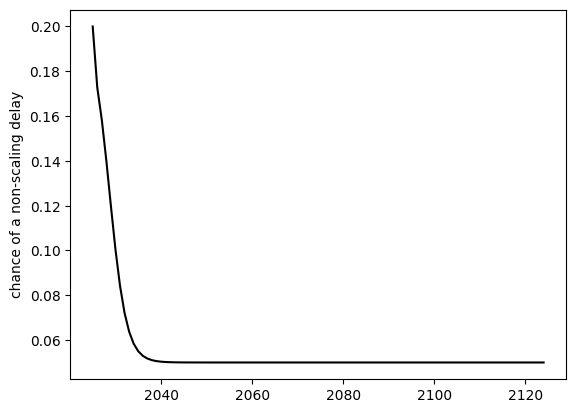

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

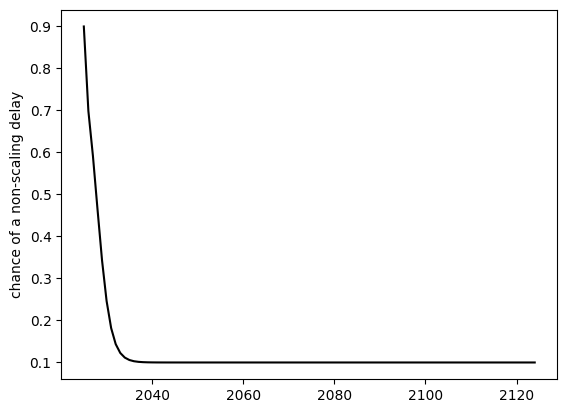

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2035

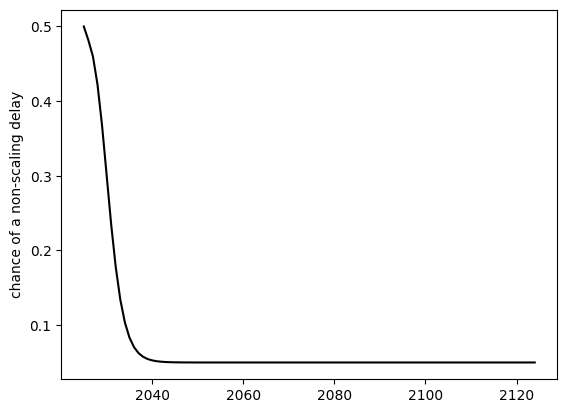

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

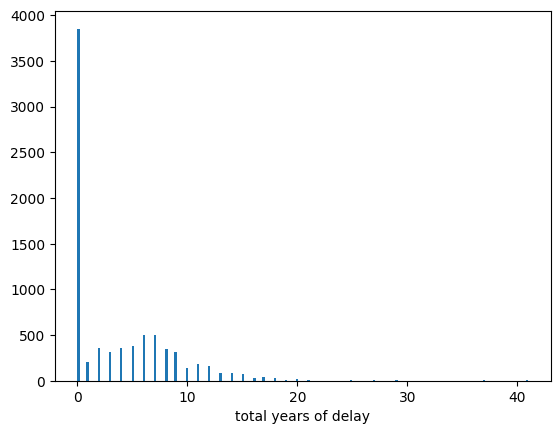

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.2 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~59.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~312.5 million).
* This doubles every 1.0 year to a max of 0.107555% of GDP (initially ~26.7 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 32.9 logFLOP which cost

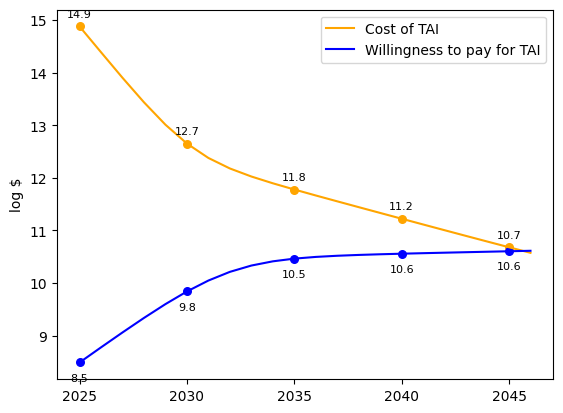

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 39.4 log FLOP (~2.5 million decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~37.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 0.8 year to a max of 0.025444% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 39.4 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 39.2 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 39.0 logFLOP which costs 20.0 log 2025$USD to buy vs. WTP at 9.6 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 38.8 logFLOP which c

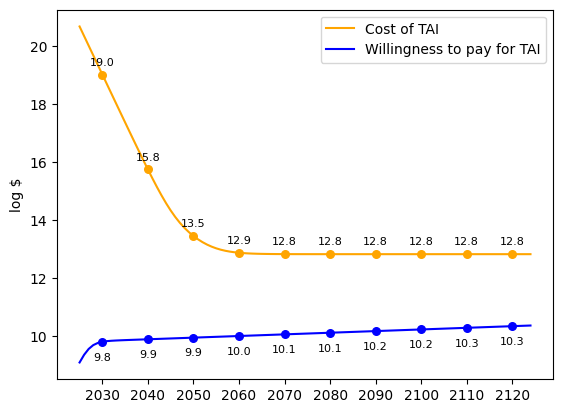

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 32.1 log FLOP (~125.9 nonillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~876.1 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~170.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~777.3 million).
* This doubles every 1.4 year to a max of 0.143932% of GDP (initially ~36.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 32.1 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 31.6 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 30.6 logFLOP which c

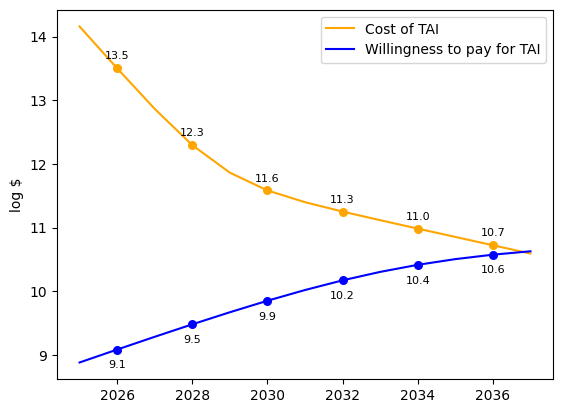

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~3.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.6 billion).
* This doubles every 1.3 year to a max of 0.029662% of GDP (initially ~7.5 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 28.0 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 27.8 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.9 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -> No

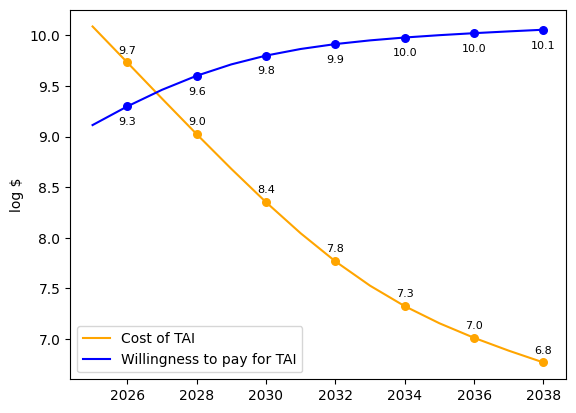

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~948.2 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~49.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~764.1 million).
* This doubles every 2.6 year to a max of 0.080276% of GDP (initially ~20.1 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.9 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 27.8 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 27.7 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 27.5 logFLOP which costs 9

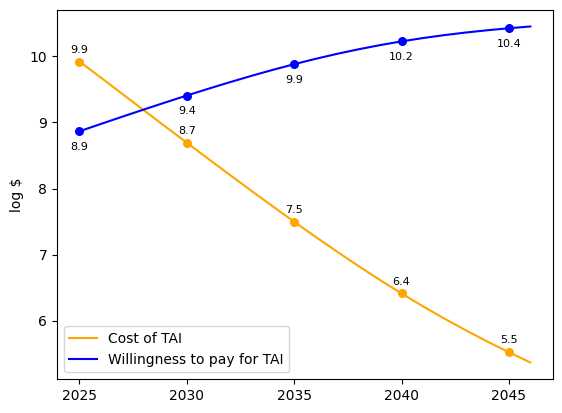

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.2 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~663.5 million).
* This doubles every 1.0 year to a max of 0.003327% of GDP (initially ~839.7 million 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6

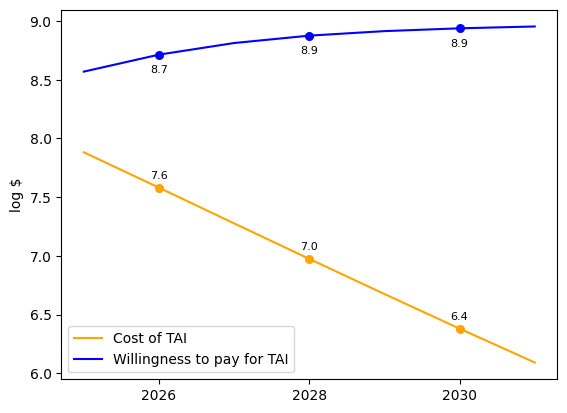

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.3 log FLOP (~195.1 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~68.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.0 million).
* This doubles every 1.2 year to a max of 0.024874% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.6 (buys 25.9 log FLOP or 25.9 2025-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 8.9 (buys 26.3 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 34.0 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 9.1 (buys 26.6 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 33.6 logFLOP which cos

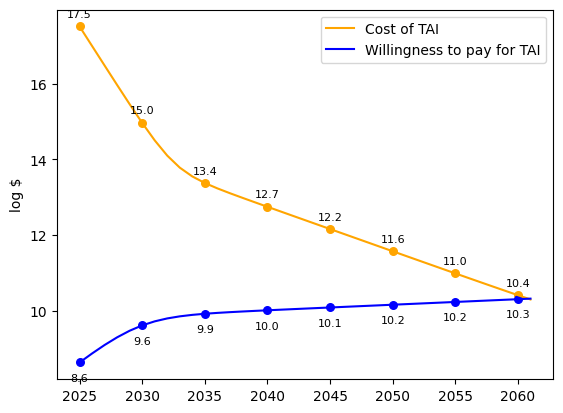

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 31.1 log FLOP (~12.6 nonillion) for transformative capabilities.
* Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~2.9 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 2.2 year to a max of 0.014404% of GDP (initially ~3.6 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 31.1 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 31.0 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 30.9 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which costs 12

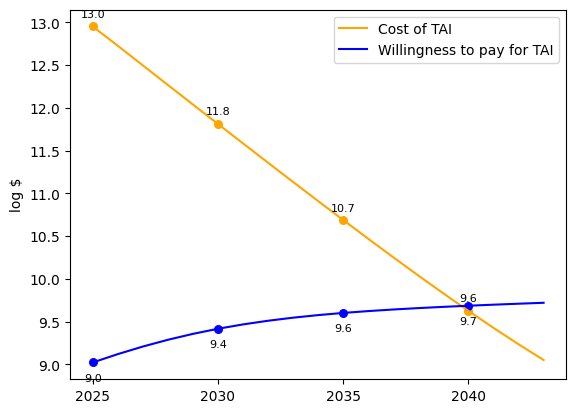

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 25.6 log FLOP (~39.8 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~50.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 0.9 year to a max of 0.010129% of GDP (initially ~2.5 billion 2025$USD).
* GDP grows at a rate of 1.05x per year.
---
2025 - TAI takes 25.6 logFLOP which costs 7.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6 more

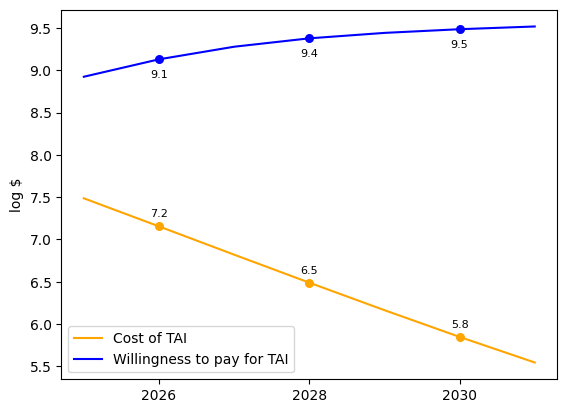

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~7.0 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~894.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~944.4 million).
* This doubles every 1.7 year to a max of 0.009197% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 7.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 6

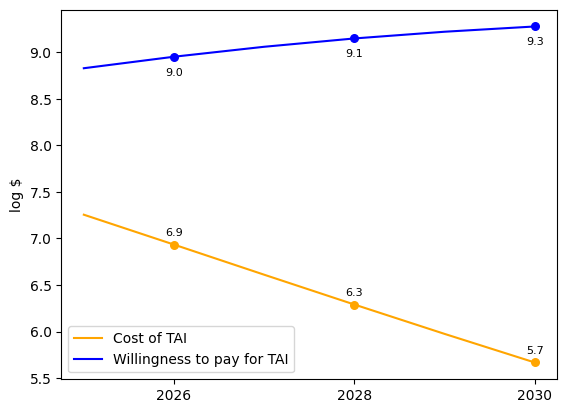

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 32.8 log FLOP (~631.0 nonillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~106.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~528.0 million).
* This doubles every 1.7 year to a max of 0.012895% of GDP (initially ~3.2 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 32.8 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 32.4 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 32.2 logFLOP which cos

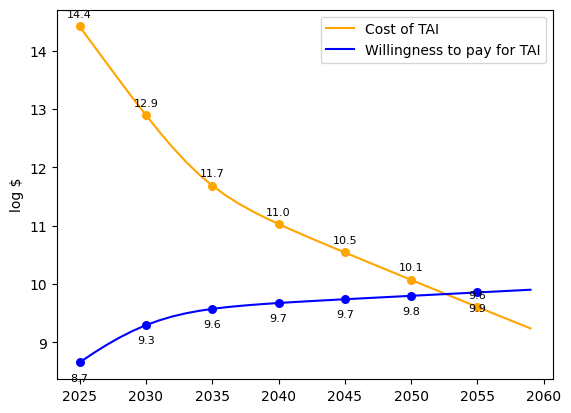

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~403.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~769.6 million).
* This doubles every 2.7 year to a max of 0.098161% of GDP (initially ~24.7 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 32.1 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 32.0 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.8 logFLOP which co

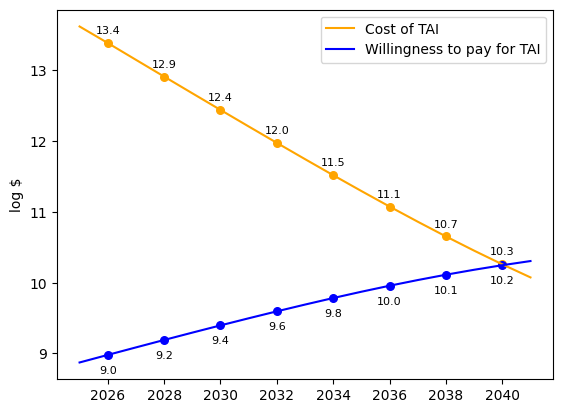

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 36.5 log FLOP (~3.2 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~890.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~5.6 billion).
* This doubles every 1.1 year to a max of 0.034365% of GDP (initially ~8.6 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 36.5 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 35.9 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 9.7 (buys 28.4 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 35.4 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 9.8 (buys 28.7 log FLOP or 29.8 2025-log-eFLOP)
2028 - TAI takes 34.8 logFLOP whic

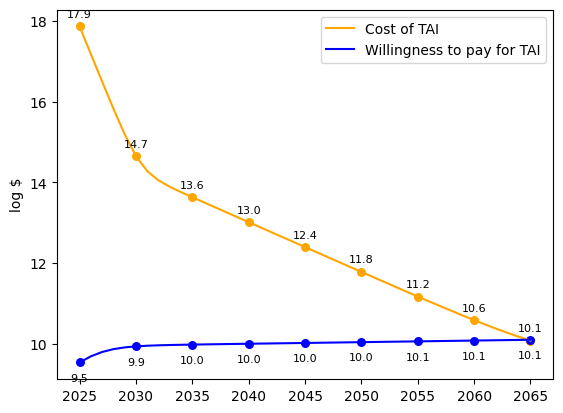

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 32.1 log FLOP (~125.9 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~27.1 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~307.2 million).
* This doubles every 1.2 year to a max of 0.04248% of GDP (initially ~10.7 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 32.1 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 31.7 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 31.0 logFLOP which cost

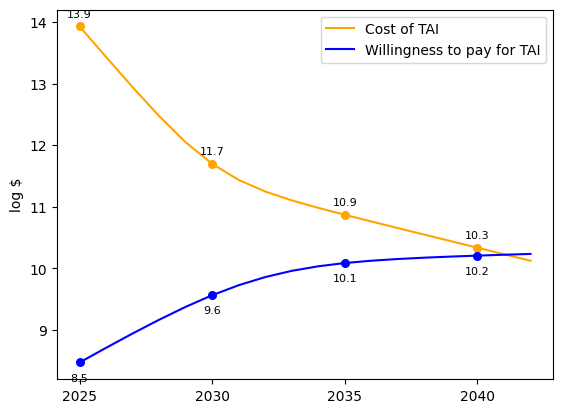

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 41.8 log FLOP (~631.0 million decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~867.2 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.0 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~584.9 million).
* This doubles every 0.7 year to a max of 0.004327% of GDP (initially ~1.1 billion 2025$USD).
* GDP grows at a rate of 1.038x per year.
---
2025 - TAI takes 41.8 logFLOP which costs 23.9 log 2025$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 41.5 logFLOP which costs 23.4 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 41.2 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 41.0 logFLOP w

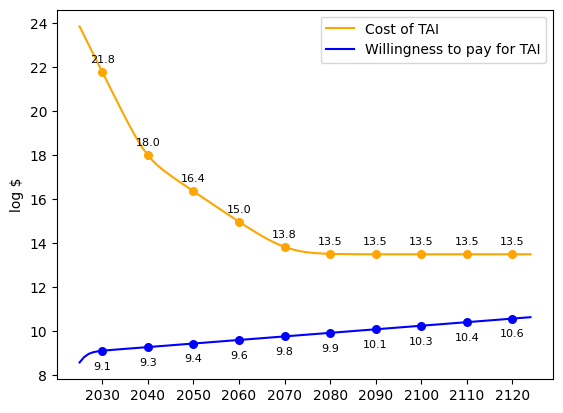

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 40.5 log FLOP (~31.6 million decillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~35.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~250.6 million).
* This doubles every 1.2 year to a max of 0.405567% of GDP (initially ~102.7 billion 2025$USD).
* GDP grows at a rate of 1.039x per year.
---
2025 - TAI takes 40.5 logFLOP which costs 22.1 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 40.4 logFLOP which costs 21.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 40.3 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP w

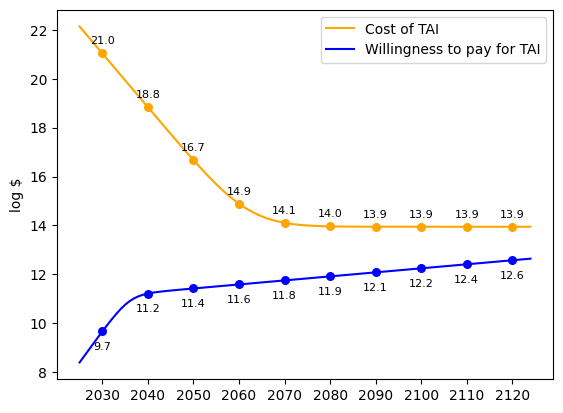

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 28.3 log FLOP (~20.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~789.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~379.4 million).
* This doubles every 1.6 year to a max of 0.03225% of GDP (initially ~8.1 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 28.3 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 27.9 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 27.7 logFLOP which costs 9

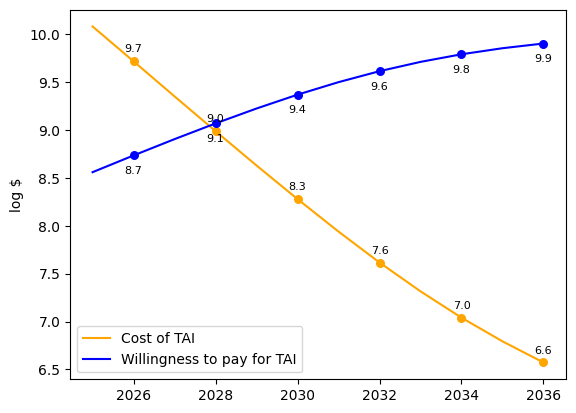

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 25.4 log FLOP (~25.1 septillion) for transformative capabilities.
* Every 2.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~316.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~383.8 million).
* This doubles every 3.8 year to a max of 0.042531% of GDP (initially ~10.7 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 25.4 logFLOP which costs 6.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 9 years (total delay 9 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 9 

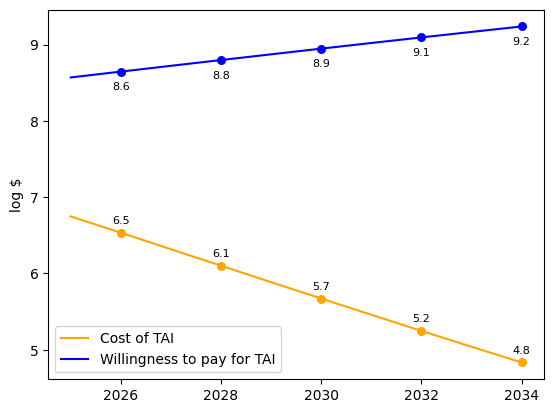

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 35.7 log FLOP (~501.2 decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.7 sextillion) per 2025$USD.
* We are initially willing to pay 10.0 log 2025$USD (~9.0 billion).
* This doubles every 0.6 year to a max of 0.126113% of GDP (initially ~31.8 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 35.7 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.8 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
2026 - TAI takes 35.6 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 10.2 (buys 28.9 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 35.4 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 10.4 (buys 29.2 log FLOP or 29.5 2025-log-eFLOP)
2028 - TAI takes 35.3 logFLOP which cos

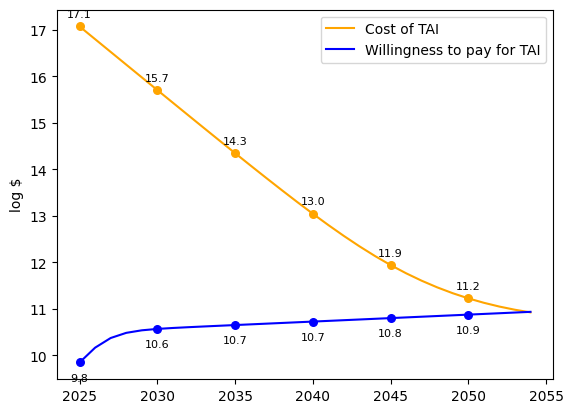

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~184.4 septillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.1 billion).
* This doubles every 1.5 year to a max of 0.046655% of GDP (initially ~11.7 billion 2025$USD).
* GDP grows at a rate of 1.041x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 29.5 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 29.2 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.8 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 29.0 logFLOP which cost

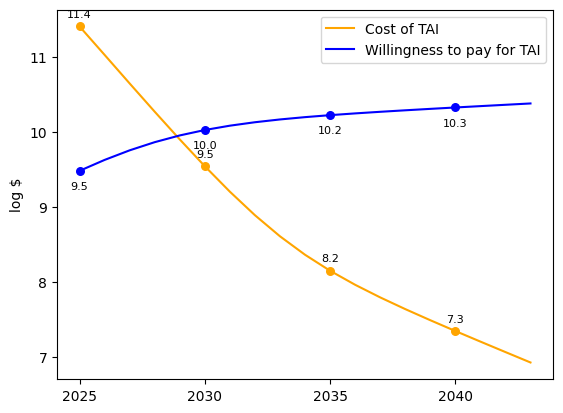

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 40.9 log FLOP (~79.4 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~45.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~976.5 million).
* This doubles every 0.8 year to a max of 0.017364% of GDP (initially ~4.4 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 40.9 logFLOP which costs 22.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 40.6 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 40.2 logFLOP which costs 21.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.4 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 39.9 logFLOP whi

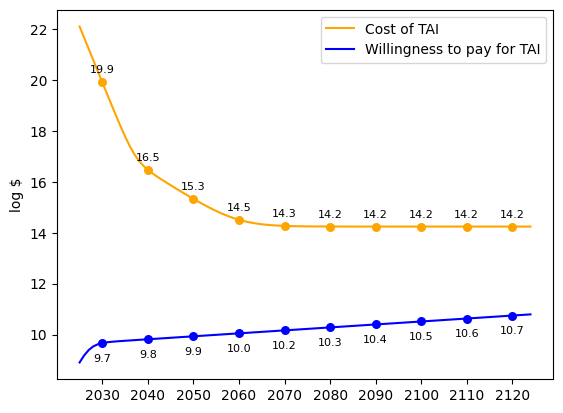

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 2.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.2 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.0 year to a max of 0.077313% of GDP (initially ~19.4 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 33.0 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 32.9 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.3 (buys 28.4 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 32.8 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.6 (buys 28.7 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 32.7 logFLOP which costs

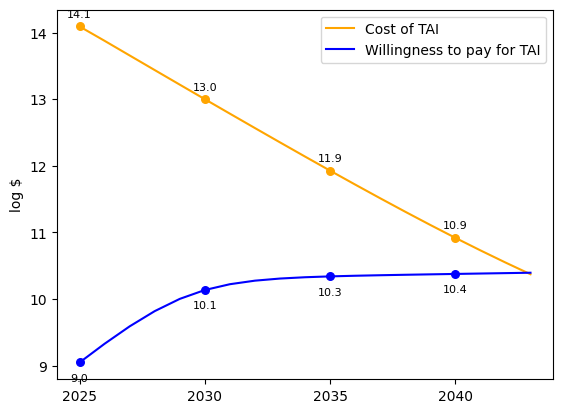

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 38.7 log FLOP (~501.2 thousand decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3.5 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~682.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~620.8 million).
* This doubles every 0.6 year to a max of 0.153453% of GDP (initially ~38.4 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 38.7 logFLOP which costs 20.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 38.5 logFLOP which costs 20.2 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 38.3 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 9.7 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 38.0 logFLO

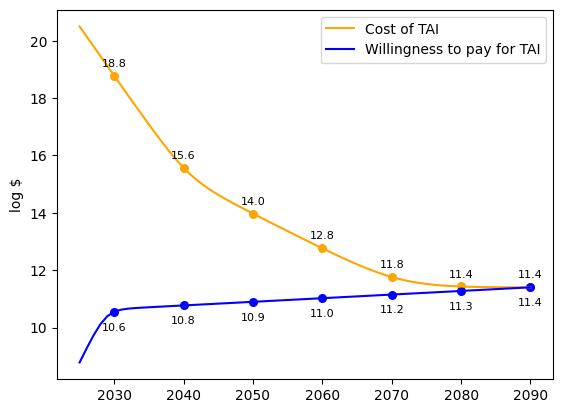

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 43.2 log FLOP (~15.8 billion decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~656.8 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~77.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.1 million).
* This doubles every 0.6 year to a max of 0.35549% of GDP (initially ~88.3 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 43.2 logFLOP which costs 25.4 log 2025$USD to buy vs. WTP at 8.5 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 43.0 logFLOP which costs 25.1 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 42.8 logFLOP which costs 24.7 log 2025$USD to buy vs. WTP at 9.6 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 42.6 logFLOP w

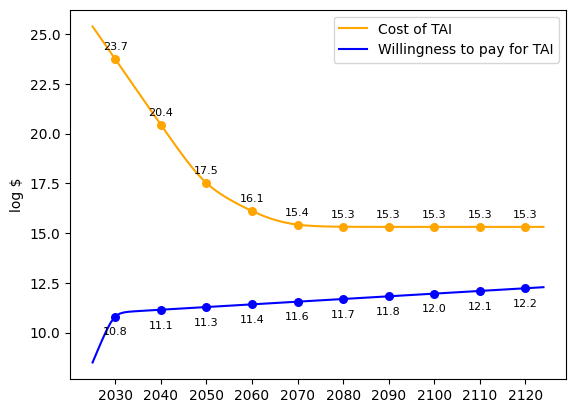

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.7 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~394.5 million).
* This doubles every 1.9 year to a max of 0.175883% of GDP (initially ~43.9 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 18.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 36.2 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 35.8 logFLOP wh

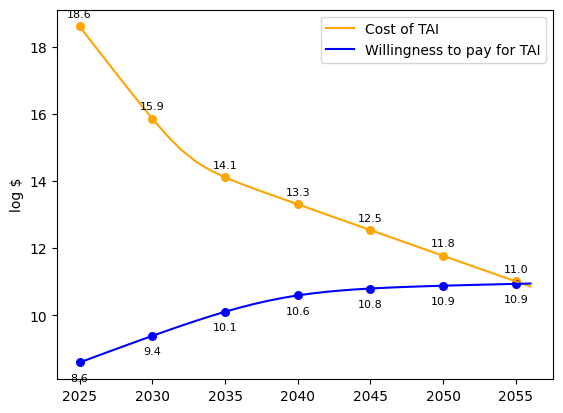

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 49.9 log FLOP (~79.4 quadrillion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 6 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~728.2 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.4 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~652.8 million).
* This doubles every 2.0 year to a max of 0.014595% of GDP (initially ~3.7 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 49.9 logFLOP which costs 32.0 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 49.6 logFLOP which costs 31.6 log 2025$USD to buy vs. WTP at 8.9 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 49.4 logFLOP which costs 31.2 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 49.1 logFLOP

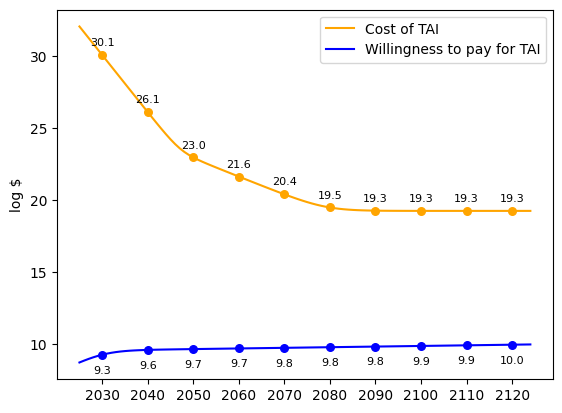

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~905.3 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~22.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~492.9 million).
* This doubles every 0.7 year to a max of 0.118372% of GDP (initially ~29.7 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs

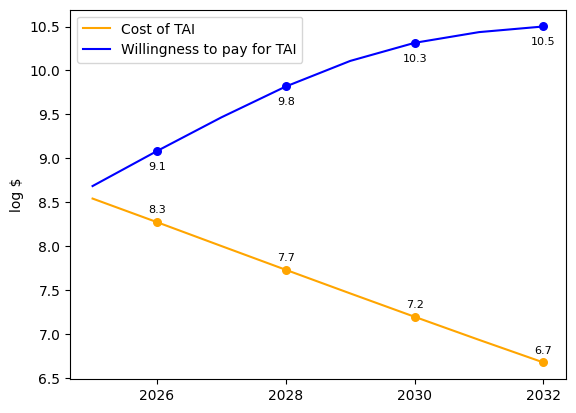

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 39.3 log FLOP (~2.0 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3.6 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~588.9 million).
* This doubles every 1.1 year to a max of 0.009147% of GDP (initially ~2.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 39.3 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 38.8 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 38.3 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 37.9 logFLOP wh

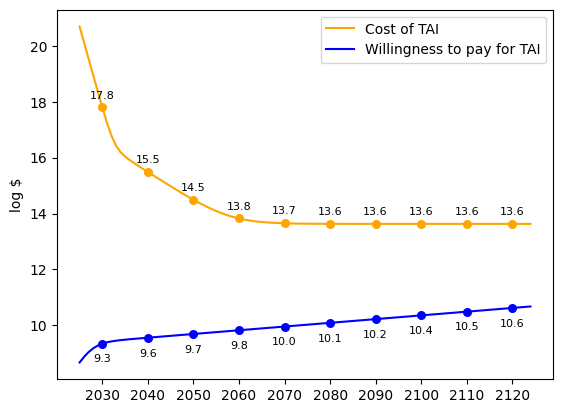

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 27.0 log FLOP (~1.0 octillion) for transformative capabilities.
* Every 2.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 26.6 log FLOP (~431.6 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~480.6 million).
* This doubles every 0.9 year to a max of 0.04671% of GDP (initially ~11.7 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 27.0 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.7 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 6 years 

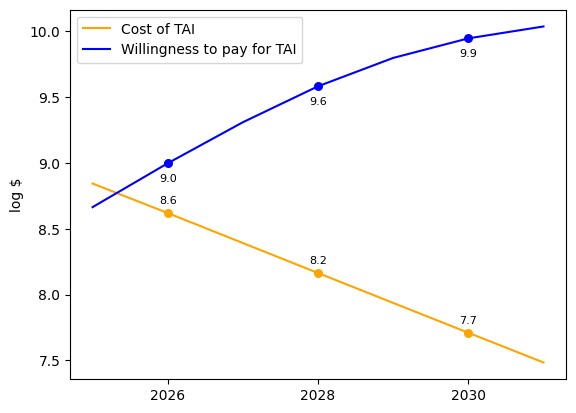

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 38.6 log FLOP (~398.1 thousand decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.7 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~230.7 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~199.3 million).
* This doubles every 0.9 year to a max of 0.653621% of GDP (initially ~165.5 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 38.6 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 8.3 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 38.4 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 38.2 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 37.9 logFL

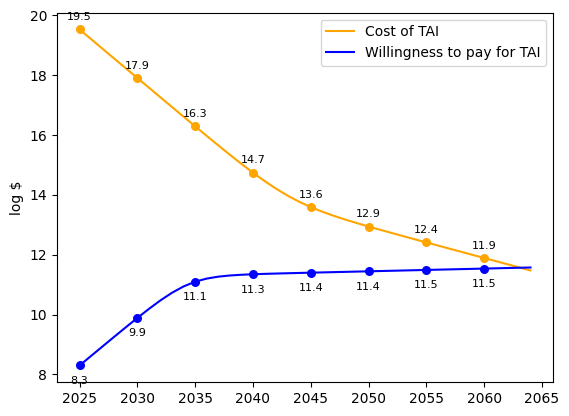

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 32.1 log FLOP (~125.9 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.4 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~98.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.1 billion).
* This doubles every 0.9 year to a max of 0.045231% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 32.1 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 31.9 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 31.6 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which costs

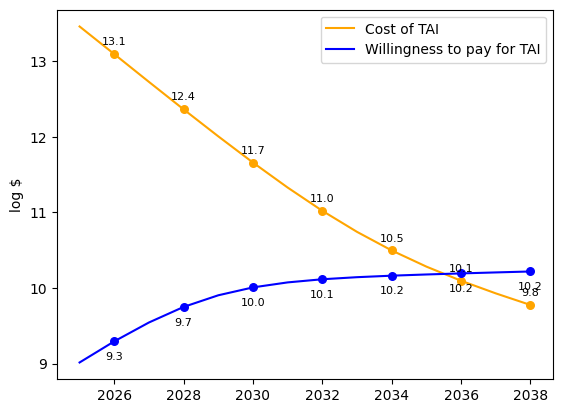

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 41.8 log FLOP (~631.0 million decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~120.6 million).
* This doubles every 0.5 year to a max of 0.011249% of GDP (initially ~2.8 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 41.8 logFLOP which costs 23.1 log 2025$USD to buy vs. WTP at 8.1 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 41.5 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 41.2 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 40.9 logFLOP whi

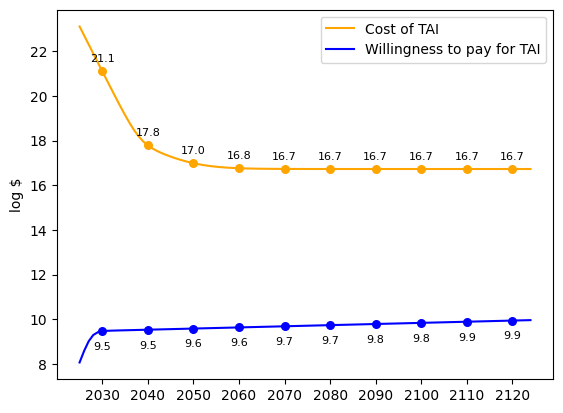

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 42.2 log FLOP (~1.6 billion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 17.4 log FLOP (~270.2 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~247.6 million).
* This doubles every 1.7 year to a max of 0.068629% of GDP (initially ~17.2 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 42.2 logFLOP which costs 24.8 log 2025$USD to buy vs. WTP at 8.4 (buys 25.8 log FLOP or 25.8 2025-log-eFLOP)
2026 - TAI takes 41.9 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.1 log FLOP or 26.4 2025-log-eFLOP)
2027 - TAI takes 41.7 logFLOP which costs 24.0 log 2025$USD to buy vs. WTP at 8.7 (buys 26.4 log FLOP or 26.9 2025-log-eFLOP)
2028 - TAI takes 41.4 logFLOP w

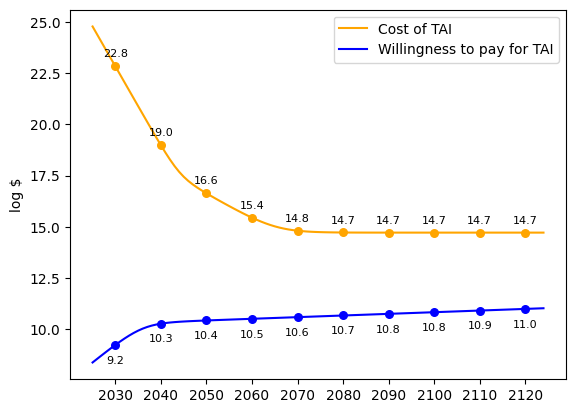

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 35.8 log FLOP (~631.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~8.9 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~981.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~958.3 million).
* This doubles every 1.3 year to a max of 0.091739% of GDP (initially ~23.0 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 35.8 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 35.4 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 35.0 logFLOP which costs 15.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.6 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 34.5 logFLOP which co

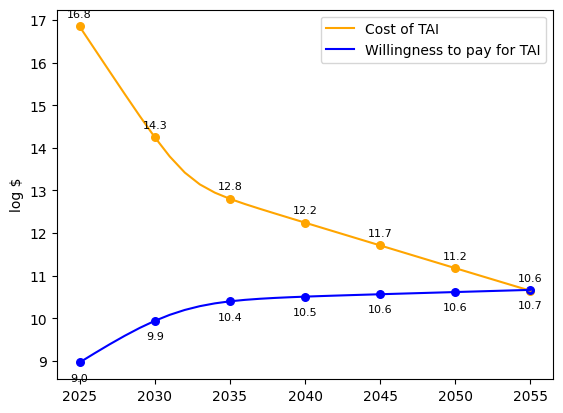

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.7 million).
* This doubles every 1.7 year to a max of 0.194412% of GDP (initially ~49.1 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 7.9 log 2025$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 m

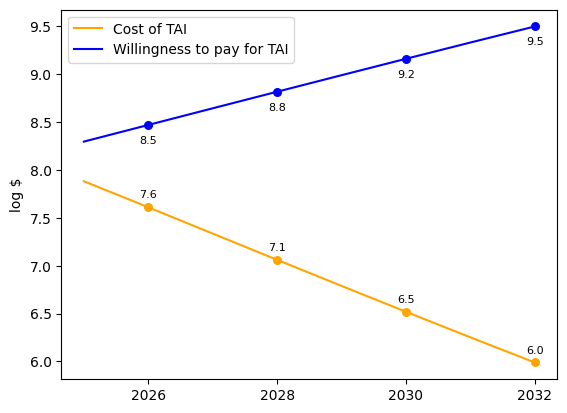

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 3.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.9 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 0.8 year to a max of 0.129891% of GDP (initially ~32.1 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 28.8 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 28.7 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.4 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 28.6 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.9 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -> 

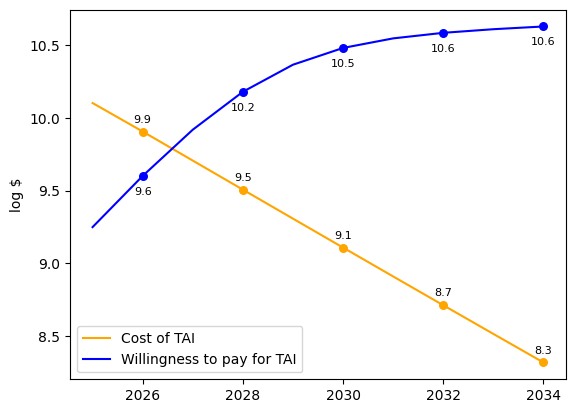

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 43.4 log FLOP (~25.1 billion decillion) for transformative capabilities.
* Every 2.2 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~104.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~500.6 million).
* This doubles every 1.9 year to a max of 1.671142% of GDP (initially ~419.9 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 43.4 logFLOP which costs 24.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 43.3 logFLOP which costs 24.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 43.1 logFLOP which costs 24.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 43.0 logFLOP 

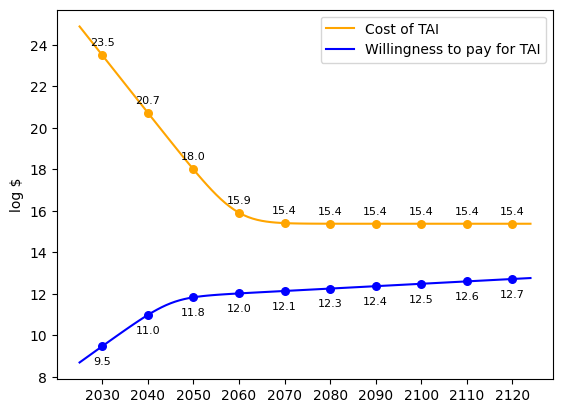

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 3.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~169.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~5.3 billion).
* This doubles every 0.8 year to a max of 0.046009% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 24.0 logFLOP which costs 5.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 17 years (total delay 17 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 19

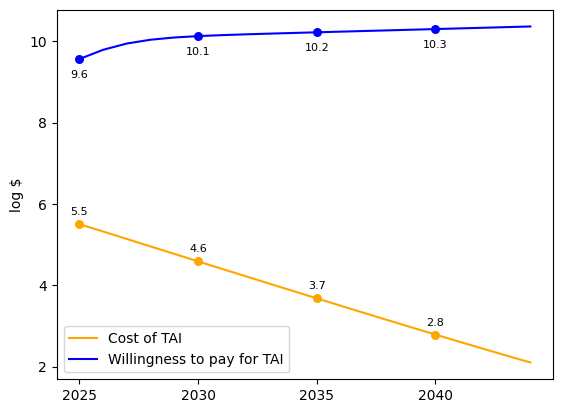

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 29.3 log FLOP (~199.5 octillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7.4 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~227.7 million).
* This doubles every 1.0 year to a max of 0.009643% of GDP (initially ~2.4 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 29.3 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 28.7 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 28.4 logFLOP which costs 

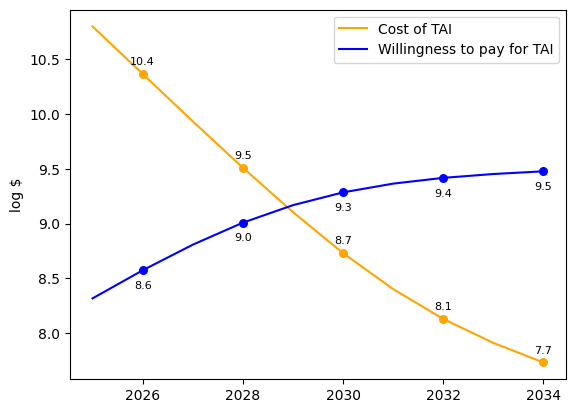

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.3 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 0.8 year to a max of 0.239957% of GDP (initially ~60.4 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 12 years (total delay 12 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 14 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -

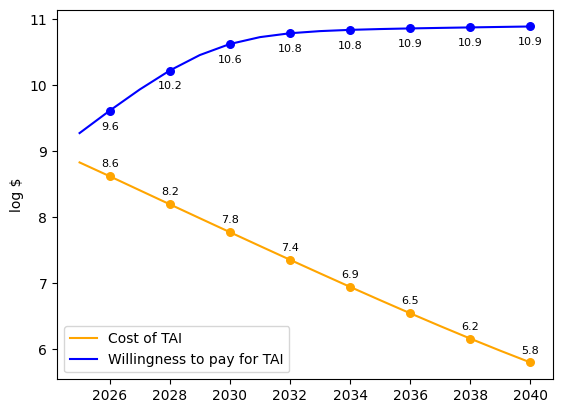

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 44.5 log FLOP (~316.2 billion decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4.0 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.4 log FLOP (~26.2 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.0 year to a max of 0.054694% of GDP (initially ~13.7 billion 2025$USD).
* GDP grows at a rate of 1.039x per year.
---
2025 - TAI takes 44.5 logFLOP which costs 26.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 44.2 logFLOP which costs 25.9 log 2025$USD to buy vs. WTP at 9.3 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 43.9 logFLOP which costs 25.5 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 43.7 logFLOP w

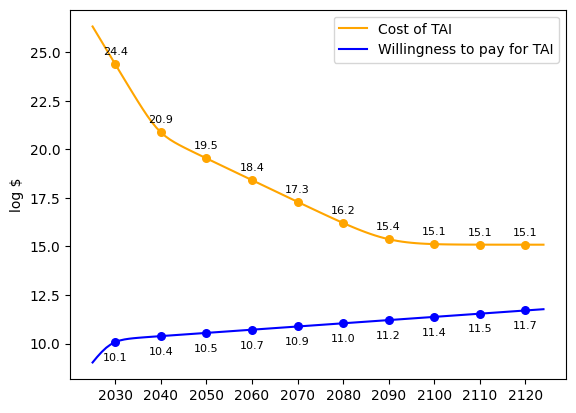

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 30.5 log FLOP (~3.2 nonillion) for transformative capabilities.
* Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~60.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~979.4 million).
* This doubles every 1.3 year to a max of 0.189953% of GDP (initially ~47.6 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 30.5 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 9.4 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 30.2 logFLOP which costs

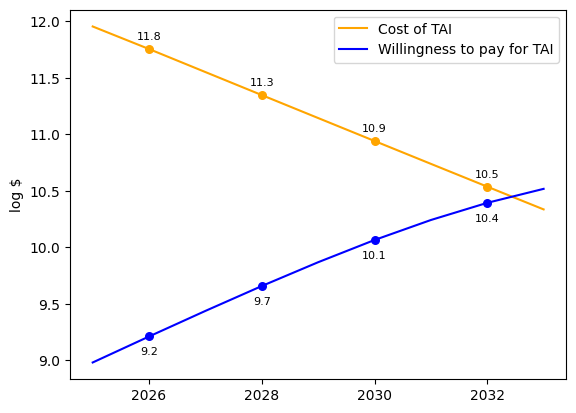

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 29.1 log FLOP (~125.9 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.7 billion).
* This doubles every 1.2 year to a max of 0.048108% of GDP (initially ~12.1 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 29.1 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 28.7 logFLOP which costs

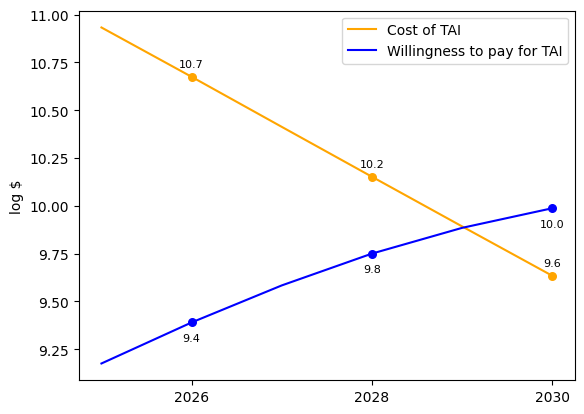

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~24.7 quintillion) per 2025$USD.
* Every 3.2 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~344.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~485.4 million).
* This doubles every 0.7 year to a max of 0.061057% of GDP (initially ~15.5 billion 2025$USD).
* GDP grows at a rate of 1.034x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 8.7 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 30.3 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.4 (buys 29.0 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 30.1 logFLOP which cos

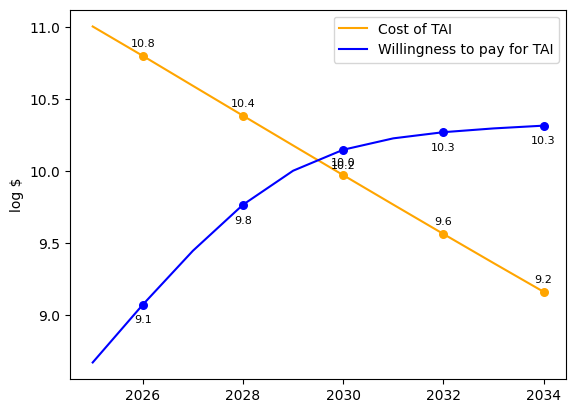

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 32.2 log FLOP (~158.5 nonillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~79.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~315.6 million).
* This doubles every 0.9 year to a max of 0.634229% of GDP (initially ~159.8 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 32.2 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 32.0 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 31.9 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which co

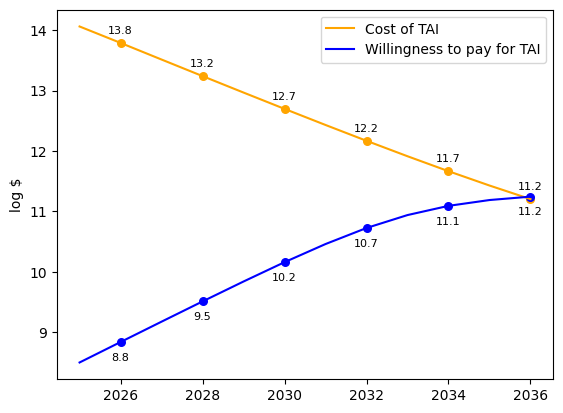

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.5 septillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.5 billion).
* This doubles every 1.4 year to a max of 0.041763% of GDP (initially ~10.5 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 10 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 11 ye

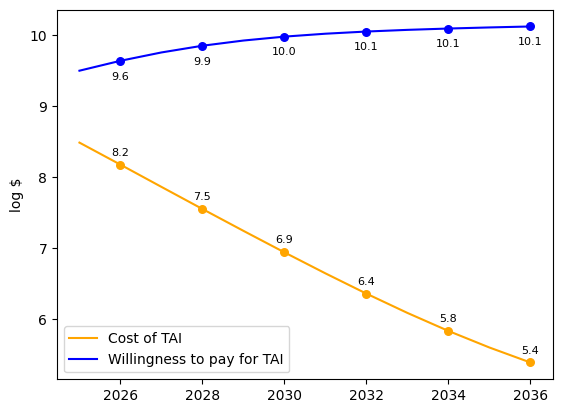

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.9 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~942.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~388.4 million).
* This doubles every 1.1 year to a max of 0.062625% of GDP (initially ~15.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 7.5 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 

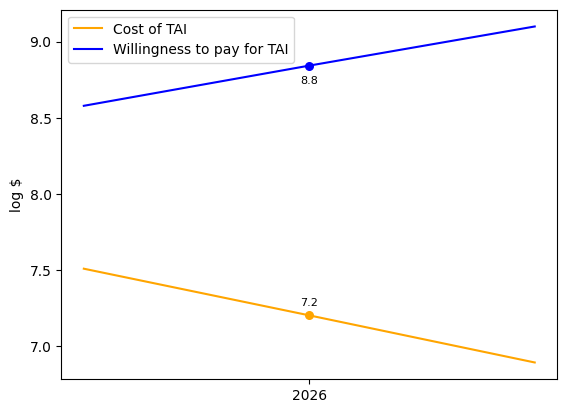

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 33.4 log FLOP (~2.5 decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.8 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~524.5 million).
* This doubles every 0.7 year to a max of 0.006152% of GDP (initially ~1.5 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 33.4 logFLOP which costs 15.4 log 2025$USD to buy vs. WTP at 8.6 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 33.2 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 32.9 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 32.7 logFLOP which costs 1

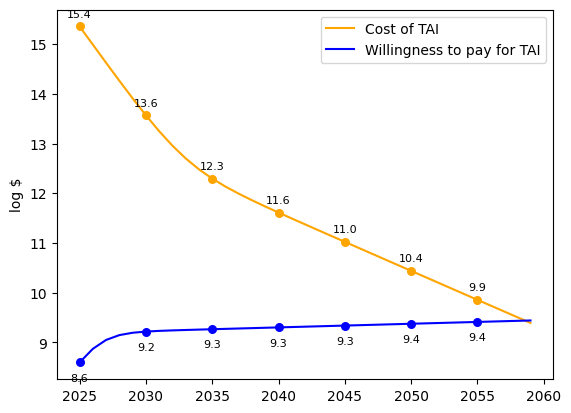

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 34.5 log FLOP (~31.6 decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~611.3 million).
* This doubles every 1.5 year to a max of 0.077751% of GDP (initially ~19.7 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 34.5 logFLOP which costs 16.4 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 34.3 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 34.1 logFLOP which costs 15.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 34.0 logFLOP which cost

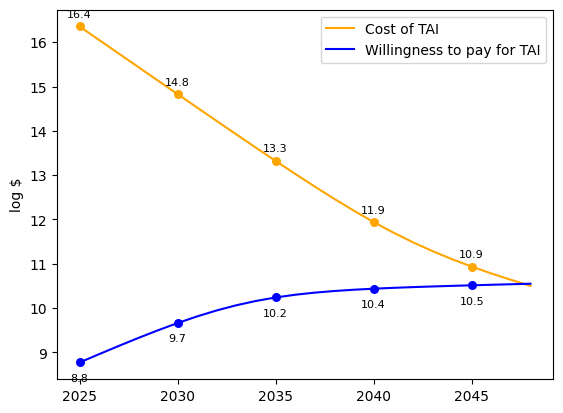

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.1 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~292.7 million).
* This doubles every 1.4 year to a max of 0.015578% of GDP (initially ~3.9 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.4 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 27.1 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 26.9 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 -> N

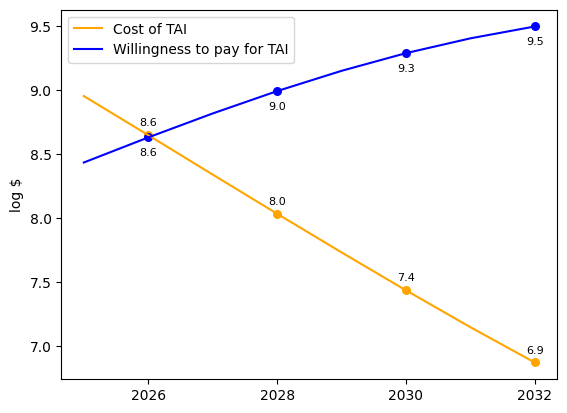

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-06-17 11:52:38.711267
